In [53]:
import numpy as np
import spglib
import pickle

In [54]:
cell= (np.array([[5.3746, 0.    , 0.    ],
       [0.    , 5.3746, 0.    ],
       [0.    , 0.    , 3.6498]]), np.array([[0.5   , 0.5   , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.3601, 0.8601, 0.5   ],
       [0.6399, 0.1399, 0.5   ],
       [0.1399, 0.3601, 0.5   ],
       [0.8601, 0.6399, 0.5   ],
       [0.1612, 0.6612, 0.5   ],
       [0.8388, 0.3388, 0.5   ],
       [0.3388, 0.1612, 0.5   ],
       [0.6612, 0.8388, 0.5   ]]), [1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

magmom = np.array([[0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.],
                    [0., 0., 0.]])
lattice = cell[0]
positions = cell[1]
numbers = cell[2]

In [55]:
spglib.get_magnetic_symmetry_dataset((*cell, magmom))

{'uni_number': 1048,
 'msg_type': 2,
 'hall_number': 406,
 'tensor_rank': 1,
 'n_operations': 32,
 'rotations': array([[[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  1]],
 
        [[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  1]],
 
        [[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0, -1]],
 
        [[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0, -1]],
 
        [[ 0, -1,  0],
         [ 1,  0,  0],
         [ 0,  0,  1]],
 
        [[ 0, -1,  0],
         [ 1,  0,  0],
         [ 0,  0,  1]],
 
        [[ 0,  1,  0],
         [-1,  0,  0],
         [ 0,  0, -1]],
 
        [[ 0,  1,  0],
         [-1,  0,  0],
         [ 0,  0, -1]],
 
        [[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0,  1]],
 
        [[-1,  0,  0],
         [ 0, -1,  0],
         [ 0,  0,  1]],
 
        [[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1]],
 
        [[ 1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1]],
 
        [[ 0,  1,  0],
  

## Symmetry indicators

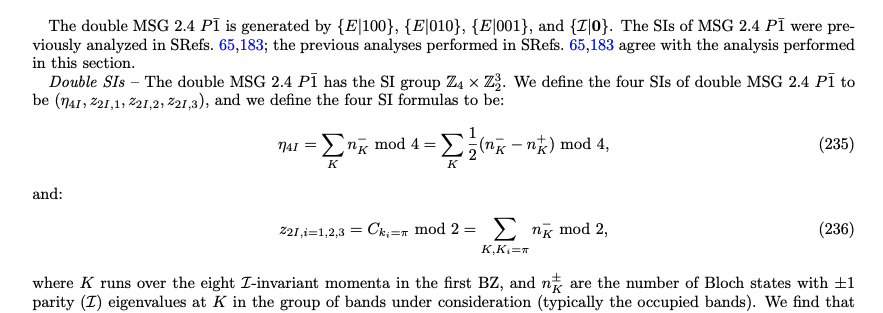

In [56]:
def is_inversion(sym):
    return (
        np.isclose(sym.translation, 0.0).all() and
        np.isclose(sym.rotation + np.eye(3), 0.0).all()
    )

def is_trim(kp):
    return (-kp.K % 1 == kp.K).all()

def eta_4I(kpoints, occ):
    assert kpoints[0].Energy.shape[0] >= occ, "Occupation is higher than computed bands"
    trims = list(filter(is_trim, kpoints))
    assert len(trims) == 8, "The number of TRIMs is not 8"
    total = 0
    for kp in trims:
        for sym in kp.symmetries.keys():
            if is_inversion(sym):
                inv = sym
                break
        inv_vals = kp.symmetries[inv].real.round()
        total += (inv_vals[:occ] == -1).sum()
    return total % 4

def z_2I_i(kpoints, occ, i):
    assert kpoints[0].Energy.shape[0] >= occ, "Occupation is higher than computed bands"
    trims = list(filter(is_trim, kpoints))
    assert len(trims) == 8, "The number of TRIMs is not 8"

    total = 0
    for kp in trims:
        if not np.isclose(kp.K[i], 0.5):
            continue
        for sym in kp.symmetries.keys():
            if is_inversion(sym):
                inv = sym
                break
        inv_vals = kp.symmetries[inv].real.round()
        total += (inv_vals[:occ] == -1).sum()

    return total % 2

def z_2I_triplet(kpoints, occ):
    indices = []
    for i in range(3):
        indices.append(z_2I_i(kpoints, occ, i))
    return tuple(indices)

def eta_prime_2I(kpoints, occ):
    return int(eta_4I(kpoints, occ) / 2) % 2


        

In [57]:
def is_C2(sym, axis):
    c2 = -np.eye(3)
    c2[axis, axis] = 1

    return np.isclose(sym.rotation - c2, 0.0).all()

In [58]:
bs = pickle.load(open("bs_co_trims.pickle", 'rb'))
sg = bs.spacegroup
kpoints = bs.kpoints